# TEST

In [1]:
import numpy as np
import pandas as pd
import xarray as xr

import os
from glob import glob

import histlib.matchup as match

from histlib.cstes import labels, zarr_dir, matchup_dir

/home1/datahome/mdemol/.miniconda3/envs/histenv2/lib/python3.9/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.scheduler.transition-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(
/home1/datahome/mdemol/.miniconda3/envs/histenv2/lib/python3.9/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.comm.recent-messages-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(


In [2]:
if True:
    from dask.distributed import Client
    from dask_jobqueue import PBSCluster
    #cluster = PBSCluster(cores=56, processes=28, walltime='04:00:00')
    #cluster = PBSCluster(cores=7, processes=7, walltime='04:00:00')
    cluster = PBSCluster(cores=10, processes=10, walltime='04:00:00')
    w = cluster.scale(jobs=5)
else:
    from dask.distributed import Client, LocalCluster
    cluster = LocalCluster()

client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: http://10.148.1.37:8787/status,
Dashboard: http://10.148.1.37:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.148.1.37:35554,Workers: 0
Dashboard: http://10.148.1.37:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


## BUILD AND STORE MATCHUP DATA

In [3]:
l = 'gps_Sentinel-3_A_2020'

In [4]:
ds = match.matchup_dataset_one(l)


In [6]:
wd_x= ['es_cstrio_z15_alti_wd_x']
wd_y = ['es_cstrio_z15_alti_wd_y']
grad_x = ['alti_ggx_adt_filtered',
     'alti_ggx_adt_unfiltered',
     'alti_ggx_adt_unfiltered_denoised',
     'alti_ggx_adt_filtered_ocean_tide',
     'alti_ggx_adt_filtered_ocean_tide_internal_tide',
     'alti_ggx_adt_filtered_ocean_tide_internal_tide_dac',
     'alti_ggx_adt_unfiltered_denoised_ocean_tide',
     'alti_ggx_adt_unfiltered_denoised_ocean_tide_internal_tide',
     'alti_ggx_adt_unfiltered_denoised_ocean_tide_internal_tide_dac']
grad_y =['aviso_alti_ggy_adt', 'aviso_drifter_ggy_adt']
dsm = match.add_except_sum(ds,wd_x=wd_x,wd_y=wd_y,grad_x=grad_x,grad_y=grad_y,)

In [15]:
def ms_dataset(dsm, l, wd_x, wd_y, grad_x, grad_y, cutoff) :
    dsm = match.add_except_sum(dsm,except_=False, wd_x=wd_x, wd_y=wd_y, grad_x=grad_x, grad_y=grad_y, cutoff=cutoff)   
    nb = dsm.sizes["obs"]
    ds = (dsm**2).mean('obs')
    ds["nb_coloc"] = nb
    ds['drifter_sat_year']=l
    ds = ds.expand_dims('drifter_sat_year')
    ds = ds.set_coords('drifter_sat_year')
    
    if "id_comb" in dsm:
        ds["id_comb"] = dsm["id_comb"]
    ## ATTRS
    for v in dsm.keys() :
        ds[v].attrs =dsm[v].attrs
        ds[v].attrs['units']=r'$m^2.s^{-4}$'
        
    return ds

In [16]:
dsms = ms_dataset(ds, l, wd_x, wd_y, grad_x, grad_y, cutoff)

In [18]:
dsms = dsms.compute()

<Axes: xlabel='drifter_sat_year'>

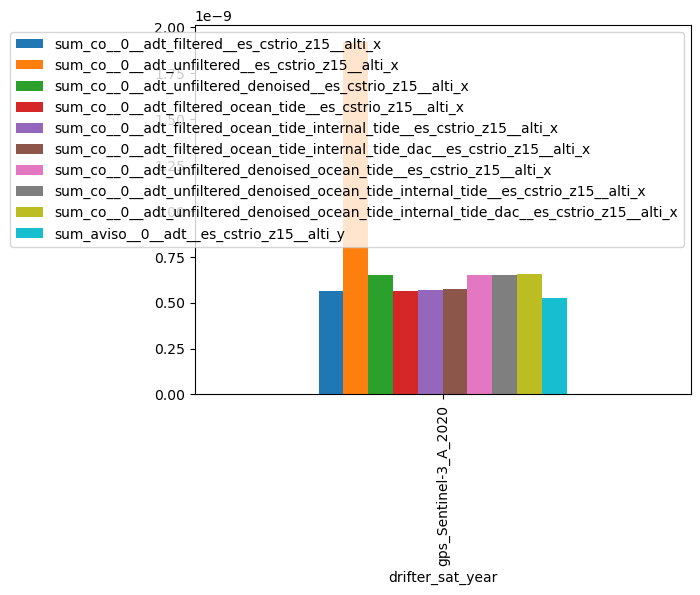

In [24]:
dsms[[l for l in dsms if 'sum' in l]].to_dataframe().plot.bar()

In [11]:
cluster.close()